In [26]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [27]:
df = pd.read_csv('stemmed_for_pca.csv', index_col=0)
df.head(10)

,stemmed,genre
0,your everyth thought never noth like thought c...,Pop
1,bodi magnifi sun set alight bodi delight burn ...,Pop
2,i'm matriarch land oh need take hand come arm ...,Pop
3,vers i'm penthous half nake cook meal nake hel...,Pop
4,everi step make everi breath take took caus ca...,Pop
5,gift virgo virgo wish could look eye tell feel...,Pop
6,know hate sleepin alon said would soon home ba...,Pop
7,yee haw oh oh oh texa texa oh oh oh texa came ...,Pop
8,girl run mutha girl run mutha girl run mutha g...,Pop
9,beyonc ain't noth missi missi elliott exclus m...,Pop


In [28]:
df.shape

(26040, 2)

In [29]:
df.isnull().sum()

stemmed    0
genre      0
dtype: int64

Below, we define a function to label each complaint narrative. And the TaggedDocument is an object-type to encapsulate a text-example function that helps to associate a tag/number with each document of the training corpus. In our case, the tag is simply the zero based line number.

In [30]:
from gensim.models import doc2vec

def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the complaint narrative.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(doc2vec.TaggedDocument(v.split(), [label]))
    return labeled

In [31]:
X_train, X_test, y_train, y_test = train_test_split(df.stemmed, df.genre, random_state=0, test_size=0.3)
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

In [32]:
len(all_data)

26040

Let's take a look at the training corpus.

In [33]:
all_data[:2]

[TaggedDocument(words=['rememb', 'seem', 'like', 'everyday', "we'r", 'start', 'go', 'day', 'better', 'other', 'get', 'tast', 'woman', 'grace', 'rememb', 'fall', 'get', 'back', 'uo', 'know', 'night', 'seem', 'like', 'gonna', 'rain', 'sometim', 'everyth', 'feel', 'wrong', 'feel', 'slip', "i'm", 'hold', 'gonna', 'alright', 'got', 'walk', 'stick', 'battlescar', "we'v", 'gone', 'door', 'never', 'open', 'get', 'tast', 'woman', 'grace', 'rememb', 'fall', 'get', 'back', 'know', 'night', 'seem', 'like', 'gonna', 'rain', 'sometim', 'everyth', 'feel', 'wrong', 'feel', 'slippin', "i'm", 'hold', 'gonna', 'alright', 'guitar', 'solo', 'rememb', 'fall', 'get', 'back', 'know', 'night', 'seem', 'like', 'go', 'rain', 'sometim', 'everyth', 'feel', 'wrong', 'gonna', 'alright'], tags=['Train_0']),
 TaggedDocument(words=["i'm", 'restless', 'willow', 'windstorm', "i'm", 'jumpi', 'puppet', 'string', "i'd", 'say', 'spring', 'fever', 'know', 'spring', 'starri', 'eye', 'vagu', 'discont', 'like', 'nightingal', 'wi

### Training the model

We'll instantiate a Doc2Vec model-Distributed Bag of Words (DBOW). In the Word2Vec architecture, the two algorithm names are “continuous bag of words” (cbow) and “skip-gram” (sg); in the Doc2Vec architecture, the corresponding algorithms are “distributed bag of words” (dbow) and “distributed memory” (dm).

### DBOW

DBOW is the Doc2Vec model analogous to Skip-gram model in Word2Vec. The paragraph vectors are obtained by training a neural network on the task of predicting a probability distribution of words in a paragraph given a randomly-sampled word from the paragraph.

Training a Doc2Vec model is rather straight forward in Gensim, we initialize the model and train for 30 epochs:

dm =0 means ‘distributed bag of words’ (DBOW), set min_count=2 means ignoring all words with total frequency lower than this, size=100 is dimensionality of the generated feature vectors, alpha=0.025 is the initial alpha rate, learning rate will linearly drop to min_alpha as training progresses. And then we build a vocabulary.

In [34]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

100%|███████████████████████████████████████████████████████████████████████| 26040/26040 [00:00<00:00, 2361404.40it/s]


In [35]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|███████████████████████████████████████████████████████████████████████| 26040/26040 [00:00<00:00, 3259607.73it/s]


Wall time: 1min 40s


Define a function to get the vectors.

In [36]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

In [37]:
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

In [38]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(alpha=0.0001, max_iter=1000, loss='log', penalty='l2', n_jobs=-1)
sgd.fit(train_vectors_dbow, y_train)
sgd.score(test_vectors_dbow, y_test)

0.45622119815668205

In [39]:
model_dbow.save('d2v_model_dbow.doc2vec')

### Distributed Memory

Distributed Memory (DM) acts as a memory that remembers what is missing from the current context — or as the topic of the paragraph. While the word vectors represent the concept of a word, the document vector intends to represent the concept of a document.

We again instantiate a Doc2Vec model with a vector size with 100 words and iterating over the training corpus 30 times.

In [40]:
model_dm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dm.build_vocab([x for x in tqdm(all_data)])

100%|███████████████████████████████████████████████████████████████████████| 26040/26040 [00:00<00:00, 3256012.29it/s]


In [41]:
%%time
for epoch in range(30):
    model_dm.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dm.alpha -= 0.002
    model_dm.min_alpha = model_dm.alpha

100%|███████████████████████████████████████████████████████████████████████| 26040/26040 [00:00<00:00, 2896382.19it/s]


Wall time: 2min 13s


In [42]:
train_vectors_dm = get_vectors(model_dm, len(X_train), 300, 'Train')
test_vectors_dm = get_vectors(model_dm, len(X_test), 300, 'Test')

In [43]:
sgd.fit(train_vectors_dm, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [44]:
sgd.score(test_vectors_dm, y_test)

0.4015616999487967

In [45]:
model_dm.save('d2v_model_dm.doc2vec')

No handles with labels found to put in legend.


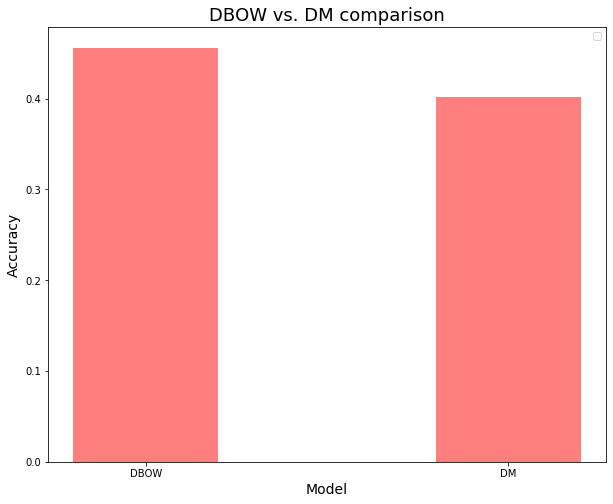

In [70]:
from matplotlib.ticker import MaxNLocator
from collections import namedtuple


fig, ax = plt.subplots(figsize = (10, 8))
index = np.arange(2)
bar_width = 0.2
accuracy = [0.45622119815668205, 0.4015616999487967]

opacity = 0.5
error_config = {'ecolor': '0.3'}

bars = ax.bar(index/2 + bar_width, accuracy, bar_width,
                alpha=opacity, color='r', align='center')

ax.set_xlabel('Model', fontsize = 14)
ax.set_ylabel('Accuracy', fontsize = 14)
ax.set_title('DBOW vs. DM comparison',  fontsize = 18)
ax.set_xticks(index/2 + bar_width)
ax.set_xticklabels(['DBOW', 'DM'])

ax.legend()


plt.show()